# Defensive Stock Analysis

Which performs better Linear regression or time series? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import zipfile
import time
from datetime import datetime
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn import preprocessing
from sklearn import utils
import statsmodels.api as sm
from pylab import rcParams
%matplotlib inline

In [2]:
# with zipfile.ZipFile("Data/archive.zip") as zip_ref:
#     zip_ref.extractall("Data")

In [3]:
df1 = pd.read_csv('Data/sp500_companies.csv')
df2 = pd.read_csv('Data/sp500_index.csv')
df3 = pd.read_csv('Data/sp500_stocks.csv')
dfg = pd.read_csv('Data/daily_gold_rate.csv')
deth = pd.read_csv('Data/CBETHUSD.csv')
dollar = pd.read_csv('Data/DTWEXBGS.csv')
ppi = pd.read_csv('Data/WPU02850113.csv')

### Datasets 

### Dataset #1

In [4]:
df1.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,149.70,2381442449408,1.305410e+11,0.081,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.067072
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software—Infrastructure,247.11,1855296897024,9.798300e+10,0.124,Redmond,WA,United States,221000.0,"Microsoft Corporation develops, licenses, and ...",0.052254
2,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,96.41,1249782136832,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.035200
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,96.73,1249780563968,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.035200
4,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,100.79,1028229365760,5.154900e+10,0.147,Seattle,WA,United States,1544000.0,"Amazon.com, Inc. engages in the retail sale of...",0.028960


In [5]:
df1 = df1[df1['Sector'] == 'Consumer Defensive']
df1.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
11,NYQ,WMT,Walmart Inc.,Walmart Inc.,Consumer Defensive,Discount Stores,142.58,395499831296,3.458600e+10,0.084,Bentonville,AR,United States,2300000.0,Walmart Inc. engages in the operation of retai...,0.011139
13,NYQ,PG,Procter & Gamble Company (The),The Procter & Gamble Company,Consumer Defensive,Household & Personal Products,140.97,341140373504,2.136400e+10,0.013,Cincinnati,OH,United States,106000.0,The Procter & Gamble Company provides branded ...,0.009608
20,NYQ,KO,Coca-Cola Company (The),The Coca-Cola Company,Consumer Defensive,Beverages—Non-Alcoholic,61.32,264866824192,1.341400e+10,0.102,Atlanta,GA,United States,79000.0,"The Coca-Cola Company, a beverage company, man...",0.007460
22,NMS,PEP,"Pepsico, Inc.","PepsiCo, Inc.",Consumer Defensive,Beverages—Non-Alcoholic,178.05,246180839424,1.515600e+10,0.088,Purchase,NY,United States,309000.0,"PepsiCo, Inc. manufactures, markets, distribut...",0.006934
23,NMS,COST,Costco Wholesale Corporation,Costco Wholesale Corporation,Consumer Defensive,Discount Stores,515.47,228575887360,9.693000e+09,0.150,Issaquah,WA,United States,304000.0,"Costco Wholesale Corporation, together with it...",0.006438


### Dataset #2

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2519 non-null   object 
 1   S&P500  2519 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB


In [7]:
df2.head()

,Date,S&P500
0,2012-11-12,1380.03
1,2012-11-13,1374.53
2,2012-11-14,1355.49
3,2012-11-15,1353.33
4,2012-11-16,1359.88


In [8]:
df2.shape

(2519, 2)

In [9]:
df2['Date'] = pd.to_datetime(df2['Date'],infer_datetime_format=True)

In [10]:
# df2=df2[df2['Date'] >= '2019-01-1']

In [11]:
df2 = df2.rename(columns={"S&P500":"S&PClose"})

In [12]:
df2['Symbol'] = "S&P500"

In [13]:
df2.head()

,Date,S&PClose,Symbol
0,2012-11-12,1380.03,S&P500
1,2012-11-13,1374.53,S&P500
2,2012-11-14,1355.49,S&P500
3,2012-11-15,1353.33,S&P500
4,2012-11-16,1359.88,S&P500


In [14]:
df2.isna().sum()

Date        0
S&PClose    0
Symbol      0
dtype: int64

### Dataset #3

In [15]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629217 entries, 0 to 1629216
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Date       1629217 non-null  object 
 1   Symbol     1629217 non-null  object 
 2   Adj Close  1560290 non-null  float64
 3   Close      1560290 non-null  float64
 4   High       1560290 non-null  float64
 5   Low        1560290 non-null  float64
 6   Open       1560290 non-null  float64
 7   Volume     1560290 non-null  float64
dtypes: float64(6), object(2)
memory usage: 99.4+ MB


In [16]:
df3['Date'] = pd.to_datetime(df3['Date'])

In [17]:
df3 = df3.drop(['Adj Close', 'High', 'Low', 'Open', 'Volume'], axis=1)

In [18]:
df3.head()

,Date,Symbol,Close
0,2010-01-04,MMM,83.019997
1,2010-01-05,MMM,82.500000
2,2010-01-06,MMM,83.669998
3,2010-01-07,MMM,83.730003
4,2010-01-08,MMM,84.320000


In [19]:
df3 = df3.loc[df3['Symbol'].isin(['PEP', 'KO', 'PG', 'WMT', 'COST'])]

In [20]:
df3.isna().sum()

Date      0
Symbol    0
Close     0
dtype: int64

In [21]:
df3['Date'] = pd.to_datetime(df3['Date'],infer_datetime_format=True)

In [22]:
# df3=df3[df3['Date'] >= '2019-01-1']

In [23]:
df3.head()

,Date,Symbol,Close
382202,2010-01-04,KO,28.520000
382203,2010-01-05,KO,28.174999
382204,2010-01-06,KO,28.165001
382205,2010-01-07,KO,28.094999
382206,2010-01-08,KO,27.575001


### Dfg 

In [24]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9824 entries, 0 to 9823
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9824 non-null   object 
 1   USD     9824 non-null   float64
 2   EUR     9824 non-null   float64
 3   GBP     9824 non-null   float64
 4   INR     9824 non-null   float64
 5   AED     9824 non-null   float64
 6   CNY     9820 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.4+ KB


In [25]:
dfg = dfg.drop(['EUR','GBP','INR','AED','CNY'],axis=1)

In [26]:
dfg = dfg.rename(columns={"USD":"Gold"})

In [27]:
dfg.isna().sum()

Date    0
Gold    0
dtype: int64

In [28]:
dfg['Date'] = pd.to_datetime(dfg['Date'],infer_datetime_format=True)

In [29]:
# dfg=dfg[dfg['Date'] >= '2019-01-1']

In [30]:
dfg.head()

,Date,Gold
0,1985-01-01,308.30
1,1985-01-02,305.50
2,1985-01-03,302.30
3,1985-01-04,303.15
4,1985-01-07,298.25


In [31]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9824 entries, 0 to 9823
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9824 non-null   datetime64[ns]
 1   Gold    9824 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 153.6 KB


### Deth

In [32]:
deth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DATE      1827 non-null   object
 1   CBETHUSD  1827 non-null   object
dtypes: object(2)
memory usage: 28.7+ KB


In [33]:
deth.isna().sum()

DATE        0
CBETHUSD    0
dtype: int64

In [34]:
deth = deth.rename(columns={"DATE":"Date","CBETHUSD":"Ether"})

In [35]:
deth['Date'] = pd.to_datetime(deth['Date'],infer_datetime_format=True)

In [36]:
# deth=deth[deth['Date'] >= '2019-01-1']

In [37]:
deth.head()

,Date,Ether
0,2017-11-22,381.73
1,2017-11-23,406.61
2,2017-11-24,470.98
3,2017-11-25,466.77
4,2017-11-26,473.99


### Dollar

In [38]:
dollar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DATE      1305 non-null   object
 1   DTWEXBGS  1305 non-null   object
dtypes: object(2)
memory usage: 20.5+ KB


In [39]:
dollar.isna().sum()

DATE        0
DTWEXBGS    0
dtype: int64

In [40]:
dollar = dollar.rename(columns={"DATE":"Date", "DTWEXBGS":"USD"})

In [41]:
dollar['Date'] = pd.to_datetime(dollar['Date'],infer_datetime_format=True)

In [42]:
# dollar=dollar[dollar['Date'] >= '2019-01-1']

In [43]:
dollar.head()

,Date,USD
0,2017-11-20,111.261
1,2017-11-21,110.9836
2,2017-11-22,110.5642
3,2017-11-23,.
4,2017-11-24,110.0266


In [44]:
dollar.tail()

,Date,USD
1300,2022-11-14,123.5788
1301,2022-11-15,123.1759
1302,2022-11-16,123.4178
1303,2022-11-17,124.1229
1304,2022-11-18,123.9828


### PPI 

In [45]:
ppi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         479 non-null    object 
 1   WPU02850113  479 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [46]:
ppi.isna().sum()

DATE           0
WPU02850113    0
dtype: int64

In [47]:
ppi = ppi.rename(columns={"DATE":"Date", "WPU02850113":"PPI"})

In [48]:
ppi['Date'] = pd.to_datetime(ppi['Date'],infer_datetime_format=True)

In [49]:
# ppi=ppi[ppi['Date'] >= '2019-01-1']

In [50]:
ppi.head()

,Date,PPI
0,1982-12-01,100.0
1,1983-01-01,99.7
2,1983-02-01,100.4
3,1983-03-01,101.5
4,1983-04-01,102.2


### Merge datasets

In [51]:
df4 = pd.merge(df2,df3, on='Date', how='outer')

In [52]:
df4 = pd.merge(df4, dfg, on='Date')

In [53]:
df4 = pd.merge(df4, deth, on='Date')

In [54]:
df4 = pd.merge(df4, dollar, on='Date')

In [55]:
df4 = pd.merge(df4, ppi, on='Date')

In [56]:
df4.drop('Symbol_x', axis=1)

,Date,S&PClose,Symbol_y,Close,Gold,Ether,USD,PPI
0,2017-12-01,2642.22,KO,45.970001,1275.5,463.82,110.1432,186.000
1,2017-12-01,2642.22,COST,185.130005,1275.5,463.82,110.1432,186.000
2,2017-12-01,2642.22,PEP,116.779999,1275.5,463.82,110.1432,186.000
3,2017-12-01,2642.22,PG,90.360001,1275.5,463.82,110.1432,186.000
4,2017-12-01,2642.22,WMT,97.349998,1275.5,463.82,110.1432,186.000
...,...,...,...,...,...,...,...,...
185,2022-08-01,4118.63,KO,64.519997,1772.4,1629.76,121.5001,269.651
186,2022-08-01,4118.63,COST,546.809998,1772.4,1629.76,121.5001,269.651
187,2022-08-01,4118.63,PEP,176.949997,1772.4,1629.76,121.5001,269.651
188,2022-08-01,4118.63,PG,142.899994,1772.4,1629.76,121.5001,269.651


In [57]:
df4 = df4.rename(columns={'Symbol_y': 'Symbol'})

In [58]:
df4 = df4[['Date', 'Symbol', 'Close', 'S&PClose','Gold','Ether','USD','PPI']]

In [59]:
df4.head()

,Date,Symbol,Close,S&PClose,Gold,Ether,USD,PPI
0,2017-12-01,KO,45.970001,2642.22,1275.5,463.82,110.1432,186.0
1,2017-12-01,COST,185.130005,2642.22,1275.5,463.82,110.1432,186.0
2,2017-12-01,PEP,116.779999,2642.22,1275.5,463.82,110.1432,186.0
3,2017-12-01,PG,90.360001,2642.22,1275.5,463.82,110.1432,186.0
4,2017-12-01,WMT,97.349998,2642.22,1275.5,463.82,110.1432,186.0


In [60]:
df4['USD']=df4['USD'].astype(float)

In [61]:
df4['Ether']=df4['Ether'].astype(float)

In [62]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 189
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      190 non-null    datetime64[ns]
 1   Symbol    190 non-null    object        
 2   Close     190 non-null    float64       
 3   S&PClose  190 non-null    float64       
 4   Gold      190 non-null    float64       
 5   Ether     190 non-null    float64       
 6   USD       190 non-null    float64       
 7   PPI       190 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 13.4+ KB


### EDA

In [63]:
symbol_groups = df4.groupby(by='Symbol')

In [66]:
COST = symbol_groups.get_group('COST')
WMT = symbol_groups.get_group('WMT')
KO = symbol_groups.get_group('KO')
PG = symbol_groups.get_group('PG')
PEP = symbol_groups.get_group('PEP')

### WMT EDA

In [67]:
wmt_corr = WMT.corr()
wmt_corr

,Close,S&PClose,Gold,Ether,USD,PPI
Close,1.000000,0.837826,0.932504,0.640993,0.218195,0.469566
S&PClose,0.837826,1.000000,0.798416,0.891822,0.036834,0.657400
Gold,0.932504,0.798416,1.000000,0.588299,0.327380,0.568375
Ether,0.640993,0.891822,0.588299,1.000000,-0.136091,0.498839
USD,0.218195,0.036834,0.327380,-0.136091,1.000000,0.334263
PPI,0.469566,0.657400,0.568375,0.498839,0.334263,1.000000


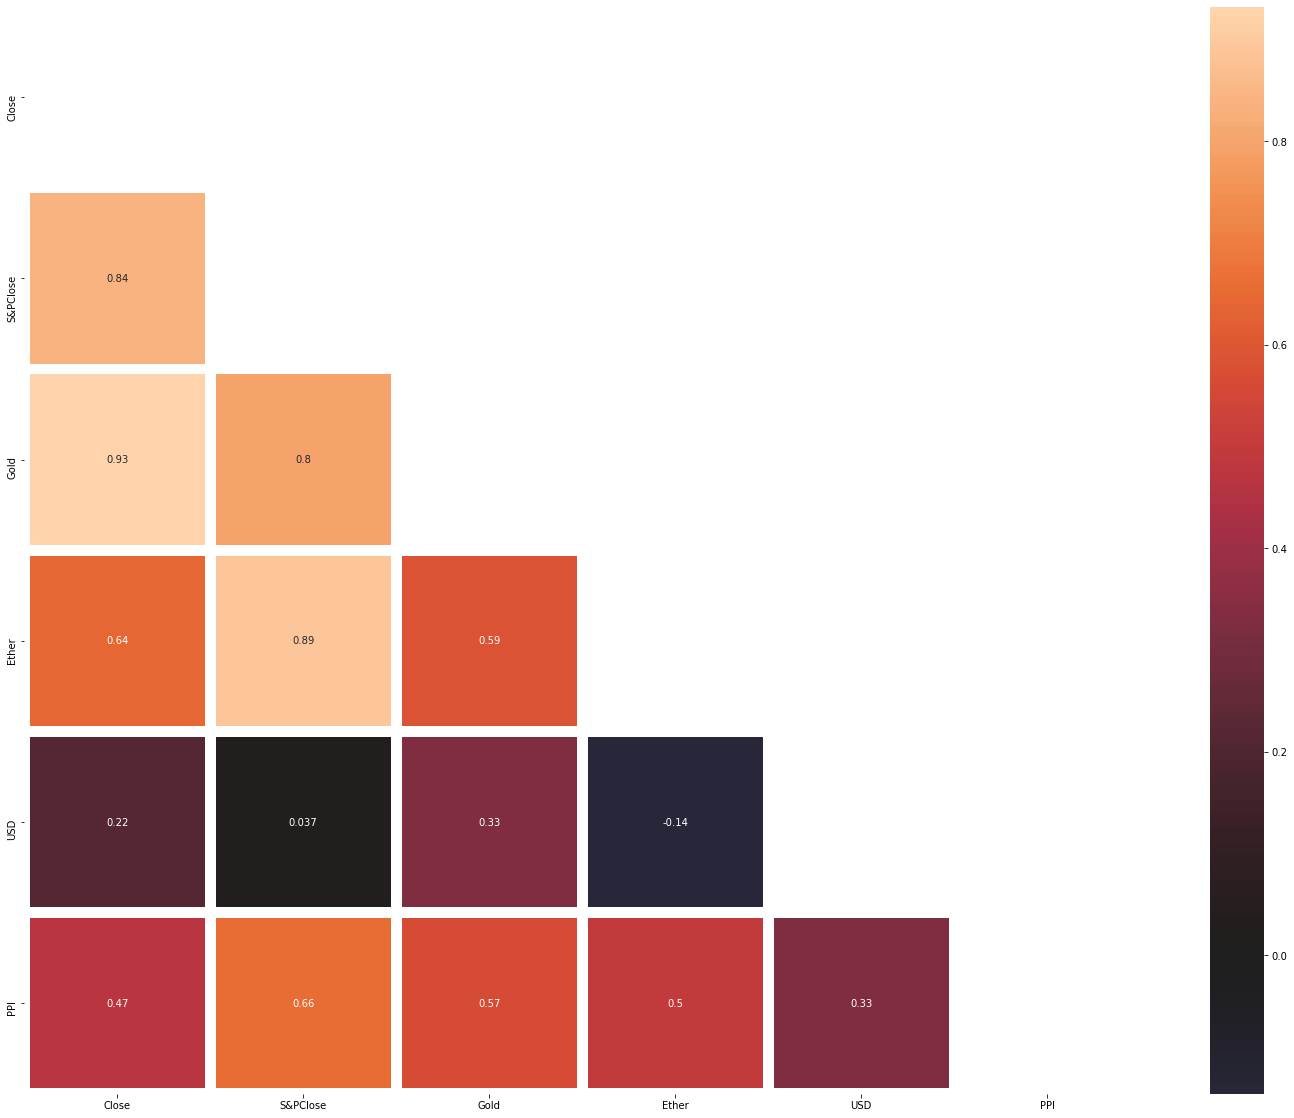

In [68]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(WMT.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(wmt_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

<AxesSubplot:xlabel='Date'>

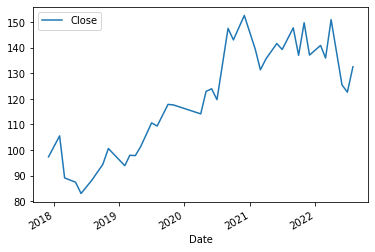

In [69]:
WMT.plot(x='Date',y='Close')

### KO EDA 

In [70]:
ko_corr = KO.corr()
ko_corr

,Close,S&PClose,Gold,Ether,USD,PPI
Close,1.000000,0.771784,0.601263,0.585042,0.256273,0.857674
S&PClose,0.771784,1.000000,0.798416,0.891822,0.036834,0.657400
Gold,0.601263,0.798416,1.000000,0.588299,0.327380,0.568375
Ether,0.585042,0.891822,0.588299,1.000000,-0.136091,0.498839
USD,0.256273,0.036834,0.327380,-0.136091,1.000000,0.334263
PPI,0.857674,0.657400,0.568375,0.498839,0.334263,1.000000


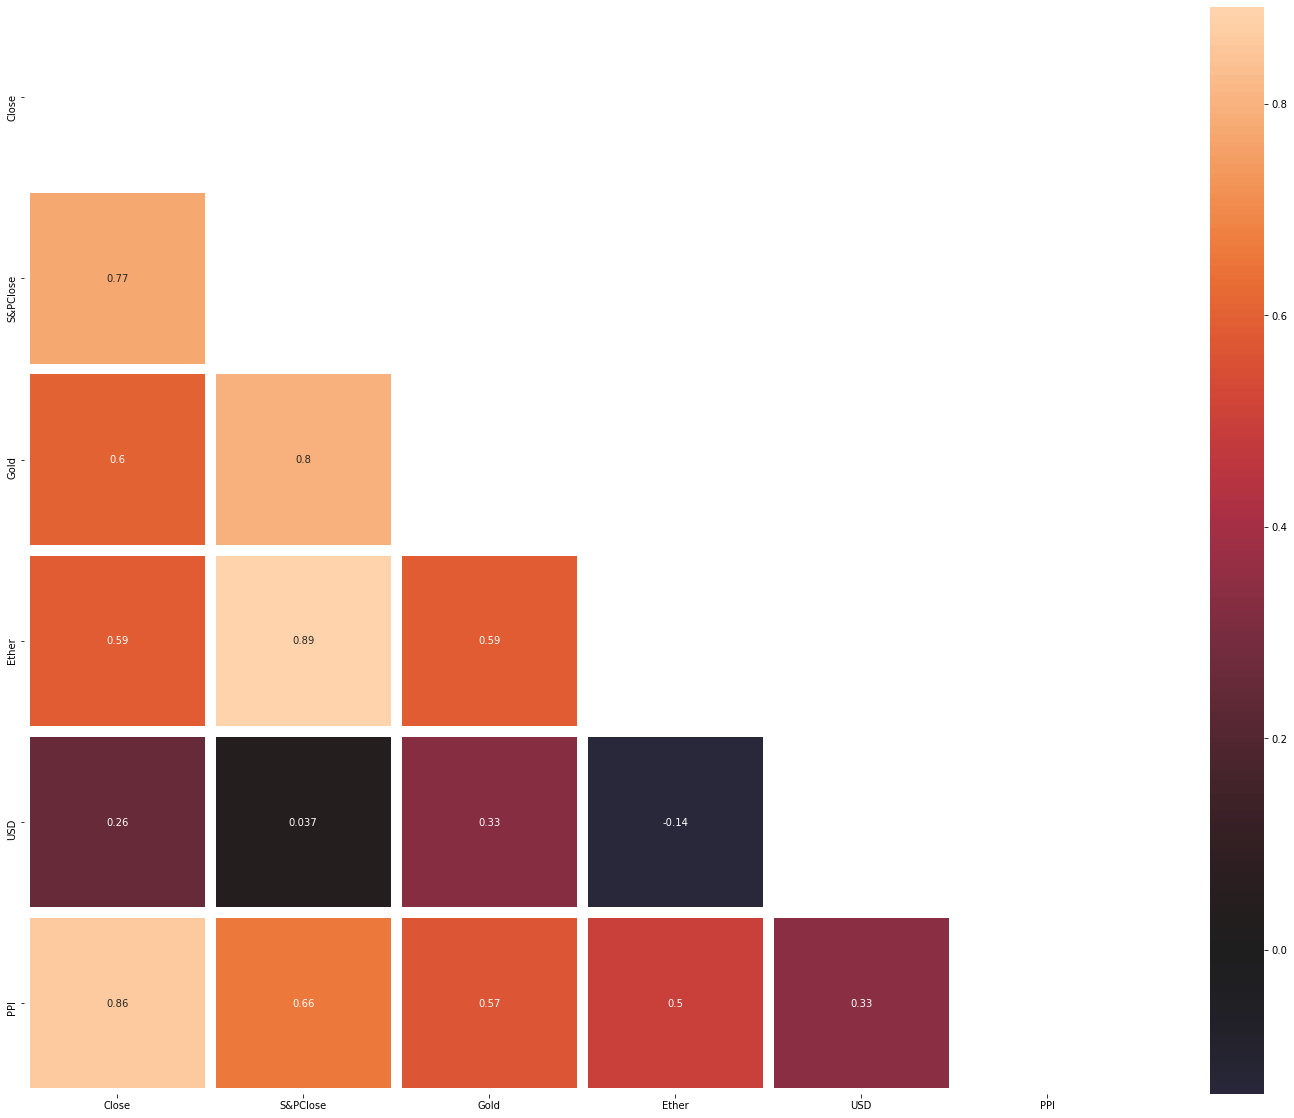

In [71]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(KO.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(ko_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

<AxesSubplot:xlabel='Date'>

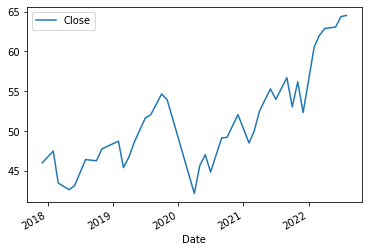

In [72]:
KO.plot(x='Date',y='Close')

### PG EDA 

In [73]:
pg_corr = PG.corr()
pg_corr

,Close,S&PClose,Gold,Ether,USD,PPI
Close,1.000000,0.859708,0.900333,0.635895,0.394046,0.679719
S&PClose,0.859708,1.000000,0.798416,0.891822,0.036834,0.657400
Gold,0.900333,0.798416,1.000000,0.588299,0.327380,0.568375
Ether,0.635895,0.891822,0.588299,1.000000,-0.136091,0.498839
USD,0.394046,0.036834,0.327380,-0.136091,1.000000,0.334263
PPI,0.679719,0.657400,0.568375,0.498839,0.334263,1.000000


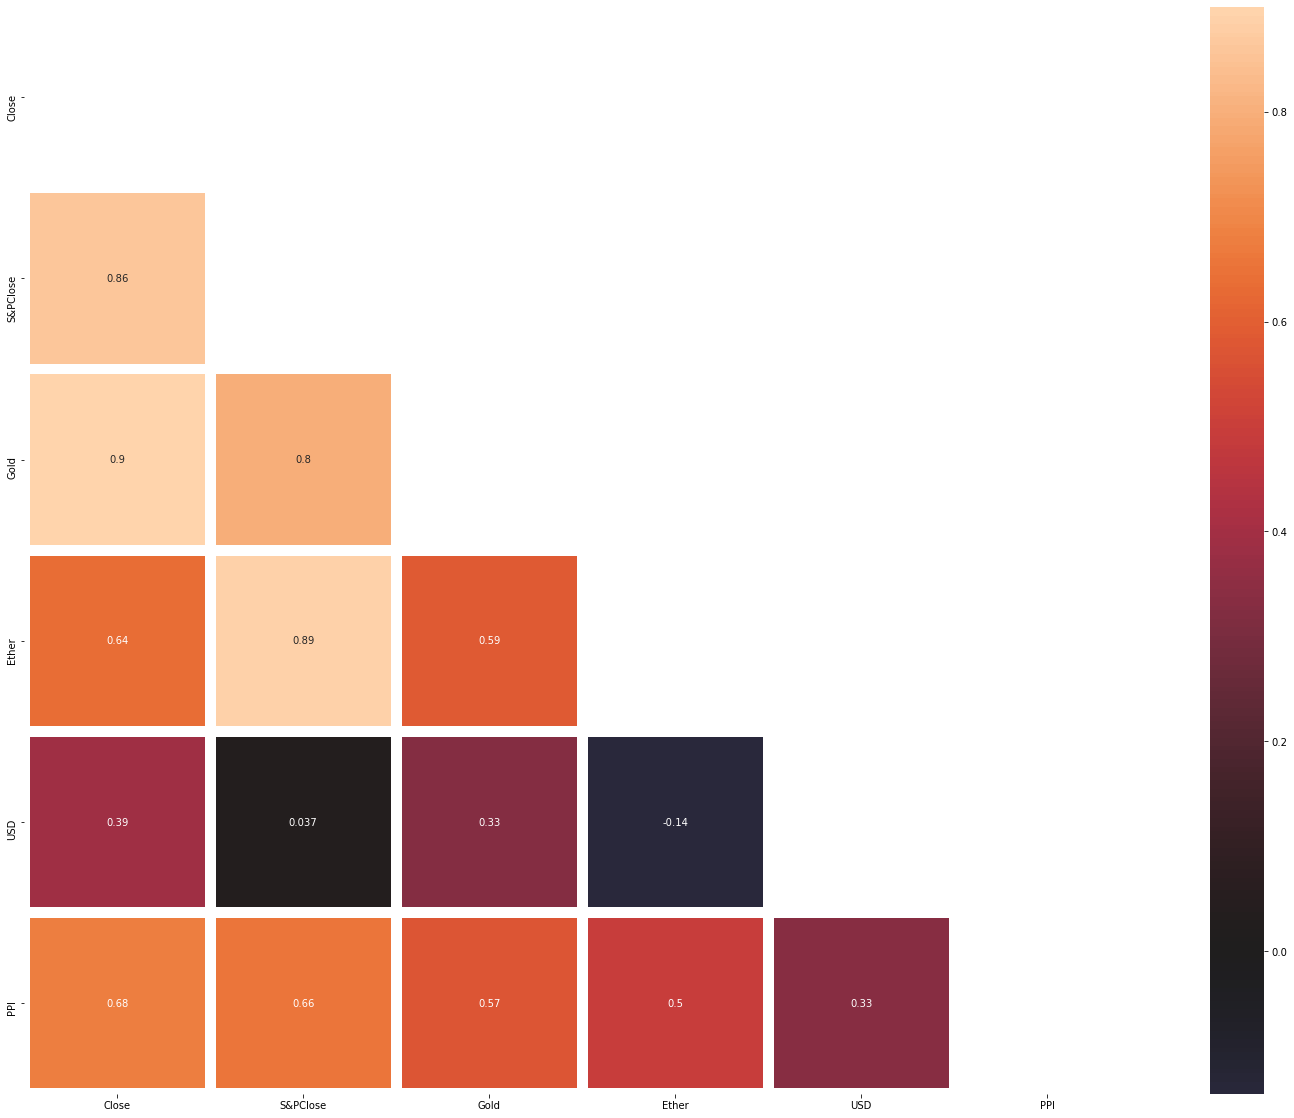

In [74]:
# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(PG.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(pg_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

<AxesSubplot:xlabel='Date'>

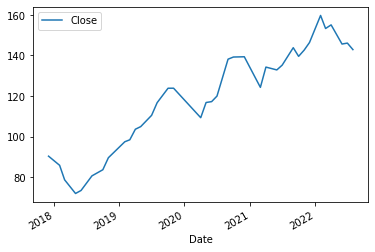

In [75]:
PG.plot(x='Date',y='Close')

### Preprocessing

In [76]:
WMT = WMT.drop(['S&PClose','Gold','PPI','Ether','USD','Symbol'],axis=1)

In [77]:
wmt_new = WMT.set_index('Date').resample('1D').pad()

In [78]:
monthly_mean = wmt_new['Close'].resample('M').mean()

In [79]:
monthly_mean['2017':]

Date
2017-12-31     97.349998
2018-01-31     97.349998
2018-02-28    105.519997
2018-03-31     89.080002
2018-04-30     89.080002
2018-05-31     87.410004
2018-06-30     82.989998
2018-07-31     82.989998
2018-08-31     88.239998
2018-09-30     88.239998
2018-10-31     94.400002
2018-11-30    100.580002
2018-12-31    100.580002
2019-01-31    100.580002
2019-02-28     93.860001
2019-03-31     97.930000
2019-04-30     97.820000
2019-05-31    101.360001
2019-06-30    101.360001
2019-07-31    110.620003
2019-08-31    109.379997
2019-09-30    109.379997
2019-10-31    117.849998
2019-11-30    117.620003
2019-12-31    117.620003
2020-01-31    117.620003
2020-02-29    117.620003
2020-03-31    117.620003
2020-04-30    114.139999
2020-05-31    122.919998
2020-06-30    123.959999
2020-07-31    119.690002
2020-08-31    119.690002
2020-09-30    147.589996
2020-10-31    143.080002
2020-11-30    143.080002
2020-12-31    152.639999
2021-01-31    152.639999
2021-02-28    139.270004
2021-03-31    131.36

### SARIMA model

In [87]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [88]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(CO2,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

In [92]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(monthly_mean, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0868         -0       -inf      0.000       0.087       0.087
ma.L1         -0.2473         -0        inf      0.000      -0.247      -0.247
ar.S.L12      -0.5830   1.08e-36   -5.4e+35      0.000      -0.583      -0.583
ma.S.L12   -2.991e+14   2.22e-33  -1.35e+47      0.000   -2.99e+14   -2.99e+14
sigma2      1.391e-11   3.48e-10      0.040      0.968   -6.69e-10    6.97e-10


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:2979: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse


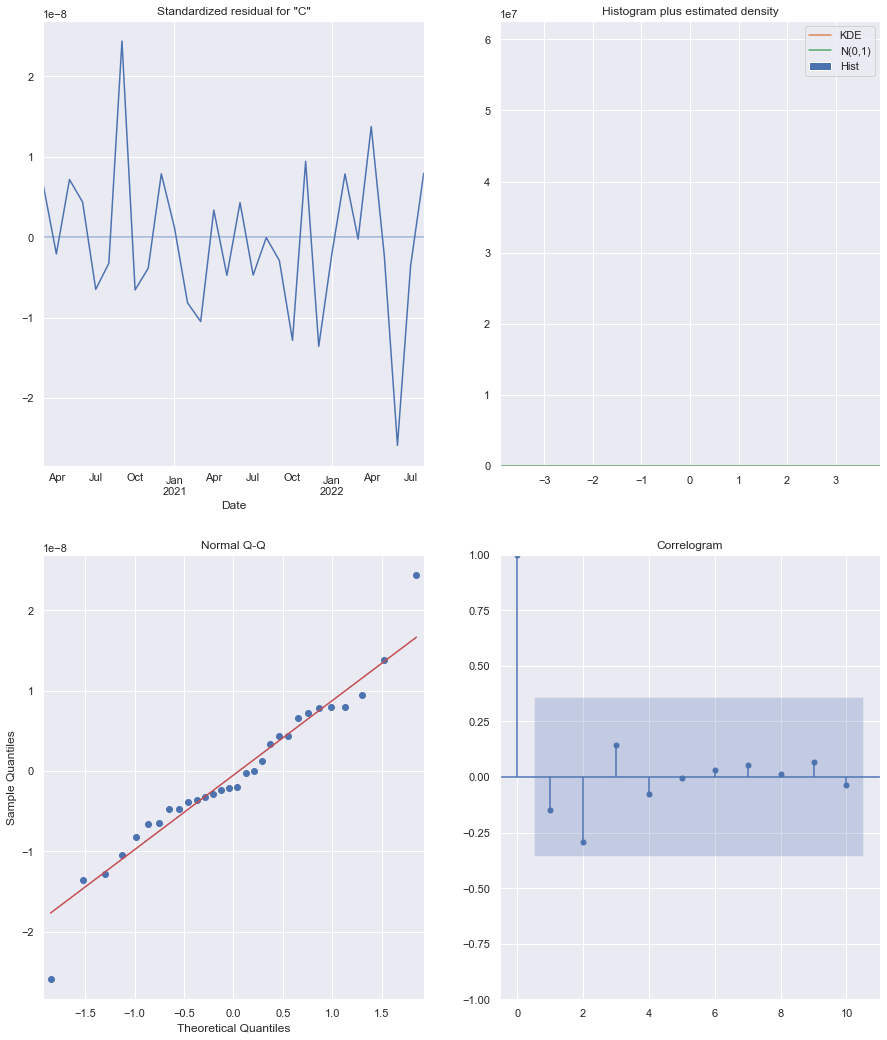

In [93]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [94]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False)
pred_conf = pred.conf_int()

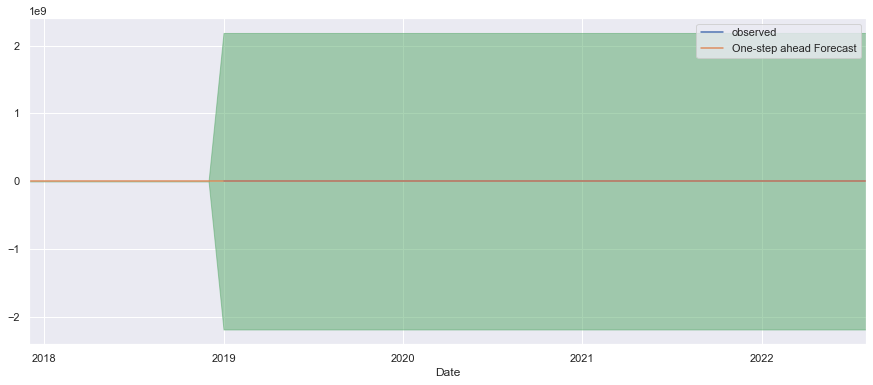

In [103]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = monthly_mean['2019-01-31':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('')
plt.legend()

plt.show()

In [100]:
# Get the real and predicted values
WMT_forecasted = pred.predicted_mean
WMT_truth = monthly_mean['2017-12-31':]

# Compute the mean square error
mse = ((WMT_forecasted - WMT_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 294.9


In [107]:
# rcParams['figure.figsize'] = 18, 8

# decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
# fig = decomposition.plot()
# plt.show()

In [108]:
# ##Checking Distribution of Our Data 
# fig = plt.figure(figsize=(10,8))
# sns.distplot(monthly_mean).set_title("Distribution Plot Adj Close -COST")
# ax.tick_params(labelsize=12)
# sns.set(font_scale=1)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

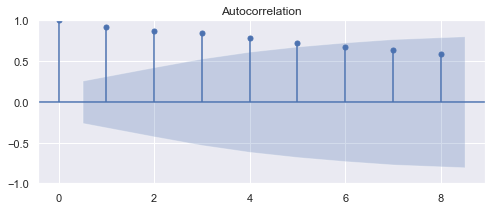

In [82]:
#Plot the ACF
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(monthly_mean,ax=ax, lags=8);

In [109]:
# #Plot the PACF
# fig, ax = plt.subplots(figsize=(8,3))
# plot_pacf(monthly_mean,ax=ax, lags=8);

In [106]:
# # Fit an ARMA(1,0) model
# mod_arma = ARIMA(monthly_mean, order=(1,0,0))
# res_arma = mod_arma.fit()

# # Print out summary information on the fit
# print(res_arma.summary())

In [105]:
# # Fit an ARMA(2,1) model
# mod_arma = ARIMA(monthly_mean, order=(2,0,1))
# res_arma = mod_arma.fit()

# # Print out summary information on the fit
# print(res_arma.summary())

In [104]:
# # Fit an ARMA(2,2) model
# mod_arma = ARIMA(monthly_mean, order=(2,0,2))
# res_arma = mod_arma.fit()

# # Print out summary information on the fit
# print(res_arma.summary())